<hr>
<h2> 0. Global Constance & Variable</h2>
Config global values
<hr>

In [1]:
_DATASET_ADDRESS_ = './dataset/'
_PICKLE_ADDRESS_ = './pickle/'
_K_ = 6
_TOP_N_PRUN_ = 10

_DELTA_ = 0.00005

In [2]:
#기본 라이브러리
import pandas as pd
import numpy as np
import math
import time
import pickle
import nashpy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

tqdm.pandas()

# SVD 행렬축소
from sklearn.decomposition import TruncatedSVD

# 제작 함수
import func
import nashpayoff as npoff

In [3]:

#데이터 불러오기
ratings = pd.read_csv("u.data.txt", header=None, sep='\t')
ratings.columns = ['userid','movieid','rating','timestamp']
ratings = ratings.drop(['timestamp'], axis=1)
print("총 주어진 ratings 데이터 : ", ratings.shape)
rating_table= pd.pivot_table(ratings, values='rating', index=['userid'], columns=['movieid'])

총 주어진 ratings 데이터 :  (100000, 3)


In [4]:
# 80000 row
user_train_raw = pd.read_csv(_DATASET_ADDRESS_ + 'u1.base', sep='\t',names=["userID","itemID","rating","timestamp"],header=None, na_filter=False)
user_train_raw = user_train_raw[['userID','itemID','rating']]
user_train = user_train_raw.pivot_table('rating', index = 'userID',columns = 'itemID').fillna(0)
user_train_raw = user_train_raw.pivot_table('rating', index = 'userID',columns = 'itemID')

# 20000 row
user_test = pd.read_csv(_DATASET_ADDRESS_ + 'u1.test', sep='\t',names=["userID","itemID","rating","timestamp"],header=None, na_filter=False)
user_test = user_test[['userID','itemID','rating']]
user_test = user_test.pivot_table('rating', index = 'userID',columns = 'itemID').fillna(0)

In [5]:
# N: num of User
try:
    with open(_PICKLE_ADDRESS_ + 'user_train.mf.pkl', 'rb') as f: 
        user_train_mf = pickle.load(f)
        print("Found existing Result...")
except FileNotFoundError:
    print("No existing Result, Calculating...")

    user_train_np = user_train.to_numpy()

    N = len(user_train_np)
    # M: num of Movie
    M = len(user_train_np[0])

    K = 5  #이거를 [5, 10, 15, 20, 25, 30]
    
    P = np.random.rand(N,K)
    Q = np.random.rand(M,K)

    #   nP, nQ = matrix_factorization(user_train_np, P, Q, K)
    #user_train_mf = pd.DataFrame(nP@nQ.T)
    with open(_PICKLE_ADDRESS_ + 'user_train.mf.pkl', 'wb') as f:
        pickle.dump(user_train, f)

Found existing Result...


<h3>Train data :</h3>
<ol>
    <li>user_train_raw : rating with <strong>NaN</strong></li>
    <li>user_train     : rating filled with <strong>0</strong></li>
    <li>user_train_mf  : rating filled by <strong>MF</strong></li>
</ol>

In [6]:
#Test for loaded datas

user_train_mf.shape, user_train_raw.shape, user_train.shape

((943, 1650), (943, 1650), (943, 1650))

<br><br><br><br><br>
<br><br><br><br><br>
<hr>
<h2> 2. Group clustering with K-means</h2>
<hr>

In [7]:
from func import clustering

train_data, test_data, km_center = clustering(_K_, user_train_mf, user_train, user_test)

c:\_CSE\Python\Anaconda\envs\KDD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [8]:
train_data.shape

(942, 1651)

<br><br><br><br><br>
<br><br><br><br><br>
<hr>
<h2> 3. Group recommendation</h2>
<ol>
    <li> 1) AVG</li>
    <li> 2) LM</li>
    <li> 3) Nash</li>
</ol>
<hr>

<h3>1) AVG</h3>

In [9]:
user_train_raw.shape
user_train_raw[1000][943]

nan

<h3>3) Nash</h3>

<strong>Step.1 Get DeltaMatrix</strong>
<div>
Get all user's delta of Group's average
</div>

In [10]:
delta_train_raw = npoff.deltaMatrix(user_train_raw)

In [11]:
df = pd.DataFrame(delta_train_raw)
df

,0,1,2,3,4,5,6,7,8,9,...,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649
0,1.000745,0.999453,1.004525,0.999123,0.998647,1.0,1.000174,0.995661,1.001244,1.000000,...,1.000007,1.000007,1.000007,1.000005,1.000007,1.0,1.000007,1.000005,1.000007,1.000007
1,1.000072,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.993321,...,1.000007,1.000007,1.000007,1.000005,1.000007,1.0,1.000007,1.000005,1.000007,1.000007
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000007,1.000007,1.000007,1.000005,1.000007,1.0,1.000007,1.000005,1.000007,1.000007
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000007,1.000007,1.000007,1.000005,1.000007,1.0,1.000007,1.000005,1.000007,1.000007
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000007,1.000007,1.000007,1.000005,1.000007,1.0,1.000007,1.000005,1.000007,1.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.001244,1.000000,...,1.000007,1.000007,1.000007,1.000005,1.000007,1.0,1.000007,1.000005,1.000007,1.000007
939,1.000000,1.000000,1.000000,0.997460,1.000000,1.0,1.000174,1.001466,0.999114,1.000000,...,1.000007,1.000007,1.000007,1.000005,1.000007,1.0,1.000007,1.000005,1.000007,1.000007
940,1.000745,1.000000,1.000000,1.000000,1.000000,1.0,1.000174,1.000000,1.000000,1.000000,...,1.000007,1.000007,1.000007,1.000005,1.000007,1.0,1.000007,1.000005,1.000007,1.000007
941,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000007,1.000007,1.000007,1.000005,1.000007,1.0,1.000007,1.000005,1.000007,1.000007


<strong>Step.2 Get payoff matrix</string>

In [14]:

payoffMatrix = npoff.payoff(4, 10, user_train_raw, delta_train_raw)

<strong>Step.3 Pruning payoff matrix</string>

In [12]:
def pruning(N, payoffMatrix) :
    #IMPORTANT : N strategy of each players, Output will be (2N * 2N)
    df1 = pd.DataFrame(payoffMatrix[0])[0:1].sort_values(by=0, axis=1, ascending=False).iloc[0,:N]
    df2 = pd.DataFrame(payoffMatrix[1])[0:1].sort_values(by=0, axis=1, ascending=False).iloc[0,:N]
    candidate = (df1.append(df2)).sort_index().index
    ret = []
    tmp1 = []
    tmp2 = []
    app1 = []
    app2 = []
    for i in df1.index :
        tmp1.append(payoffMatrix[0][i][:])
        tmp2.append(payoffMatrix[1][i][:])
    for i in df1.index :
        app1.append(np.transpose(tmp1)[i])
        app2.append(np.transpose(tmp2)[i])
        
    ret.append(np.transpose(app1))
    ret.append(np.transpose(app2))
    return ret

In [16]:
payoffMatrix = pruning(_TOP_N_PRUN_, payoffMatrix)

C:\Users\psh25\AppData\Local\Temp\ipykernel_25844\2826938188.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  candidate = (df1.append(df2)).sort_index().index


In [17]:

pruned_payoff = pruning(_TOP_N_PRUN_, payoffMatrix)
df = pd.DataFrame(pruned_payoff[0])
df

C:\Users\psh25\AppData\Local\Temp\ipykernel_25844\2826938188.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  candidate = (df1.append(df2)).sort_index().index


,0,1,2,3,4,5,6,7,8,9
0,10.118457,3.515792,3.455852,3.425643,3.296053,3.243696,3.240838,3.224478,3.210239,3.200014
1,7.666645,22.999933,8.329200,8.256392,7.944058,7.817869,7.810980,7.771549,7.737232,7.712587
2,4.199994,4.642102,10.266651,4.523073,4.351968,4.282838,4.279064,4.257463,4.238663,4.225162
3,2.999996,3.315788,3.259257,5.999992,3.108549,3.059171,3.056475,3.041046,3.027617,3.017973
4,2.124999,2.348686,2.308643,2.288462,3.914472,2.166915,2.165005,2.154076,2.144564,2.137733
5,3.228571,3.568424,3.507586,3.476925,3.345395,9.201427,3.289353,3.272748,3.258297,3.247918
6,2.499999,2.763159,2.716050,2.692309,2.590460,2.549311,5.476189,2.534207,2.523017,2.514980
7,3.173077,3.507088,3.447295,3.417162,3.287893,3.235665,3.232814,8.831730,3.202291,3.192091
8,3.693877,4.082710,4.013104,3.978024,3.827538,3.766738,3.763419,3.744421,12.449734,3.716013
9,3.761194,4.157112,4.086238,4.050519,3.897290,3.835383,3.832003,3.812659,3.795823,13.216416


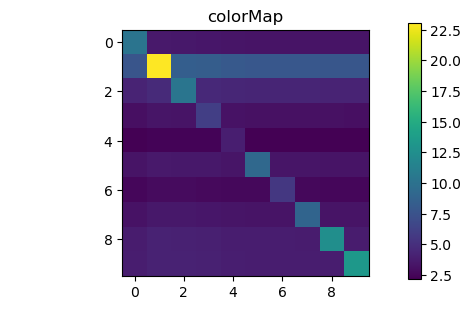

In [18]:

func.showColormap(pruned_payoff[0])

In [19]:
game = nashpy.Game(pruned_payoff[0], pruned_payoff[1])
result = next(game.vertex_enumeration())
result

(array([1.53206087e-17, 1.53206087e-17, 1.53206087e-17, 1.53206087e-17,
        1.53206087e-17, 0.00000000e+00, 1.53206087e-17, 1.00000000e+00,
        1.53206087e-17, 0.00000000e+00]),
 array([ 1.53206087e-17,  0.00000000e+00,  1.53206087e-17,  0.00000000e+00,
         1.53206087e-17,  1.53206087e-17, -1.53206087e-17,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00]))